In [1]:
import pandas as pd
import numpy as np
import keras
from datetime import datetime
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras import losses
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
import shap
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from commons import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
#sound_file = 'beep.wav'
from keras.callbacks import *

Using TensorFlow backend.
/Users/liuxuyang/opt/anaconda3/envs/mytensorflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Bitcoin

In [2]:
regs = pd.read_csv("btc_reg.csv")
btc = pd.read_csv("btc_Data.csv")
for i in range(len(btc['Date'])):
    btc['Date'][i]  =  datetime.strptime(btc['Date'][i], '%Y/%m/%d')

btc = btc.set_index("Date")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
btcData = btc[regs.columns]

In [4]:
btcData['returns'] = btcData['priceUSD'].pct_change()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]

In [6]:
Data

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.055500e+01,8.384389e+08,1.757449e+17,0.000,0.000,401834.0000,...,0.0,0,2.612000e+03,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.248600e+01,8.819952e+08,1.944789e+17,0.000,0.000,481473.0000,...,0.0,0,4.047000e+03,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,1.584060e+02,1.641620e+02,100.00,1.735570e+02,2.441400e+01,9.280542e+08,2.153212e+17,0.000,0.000,431831.0000,...,0.0,0,2.341000e+03,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475
2010-07-21,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.630400e+01,9.761949e+08,2.382391e+17,0.000,0.000,460783.0000,...,0.0,0,2.122000e+03,25.638,0.092,67.334,0.284,78.431,0.541,-0.020434
2010-07-22,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.819400e+01,1.019474e+09,2.598318e+17,0.000,0.000,334641.0000,...,0.0,0,2.570000e+03,25.604,0.078,66.526,0.275,78.166,0.537,-0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.384949e+13,4.612156e+19,5.317997e+38,165.380,0.818,0.0577,...,18820.0,28544682257,6.114577e+09,15.236,-0.080,40.118,-0.042,45.140,0.001,0.008075
2022-11-25,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.394503e+13,4.542600e+19,5.158804e+38,214.464,0.812,0.0541,...,18759.0,28076113671,7.224812e+09,15.231,-0.075,39.880,-0.043,45.047,0.001,-0.006565
2022-11-26,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.404058e+13,4.624135e+19,5.345655e+38,255.004,0.809,0.0571,...,18701.0,27566714445,4.898449e+09,15.233,-0.070,40.069,-0.043,45.106,0.001,0.004001


In [7]:
Data

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.055500e+01,8.384389e+08,1.757449e+17,0.000,0.000,401834.0000,...,0.0,0,2.612000e+03,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.248600e+01,8.819952e+08,1.944789e+17,0.000,0.000,481473.0000,...,0.0,0,4.047000e+03,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,1.584060e+02,1.641620e+02,100.00,1.735570e+02,2.441400e+01,9.280542e+08,2.153212e+17,0.000,0.000,431831.0000,...,0.0,0,2.341000e+03,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475
2010-07-21,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.630400e+01,9.761949e+08,2.382391e+17,0.000,0.000,460783.0000,...,0.0,0,2.122000e+03,25.638,0.092,67.334,0.284,78.431,0.541,-0.020434
2010-07-22,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.819400e+01,1.019474e+09,2.598318e+17,0.000,0.000,334641.0000,...,0.0,0,2.570000e+03,25.604,0.078,66.526,0.275,78.166,0.537,-0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.384949e+13,4.612156e+19,5.317997e+38,165.380,0.818,0.0577,...,18820.0,28544682257,6.114577e+09,15.236,-0.080,40.118,-0.042,45.140,0.001,0.008075
2022-11-25,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.394503e+13,4.542600e+19,5.158804e+38,214.464,0.812,0.0541,...,18759.0,28076113671,7.224812e+09,15.231,-0.075,39.880,-0.043,45.047,0.001,-0.006565
2022-11-26,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.404058e+13,4.624135e+19,5.345655e+38,255.004,0.809,0.0571,...,18701.0,27566714445,4.898449e+09,15.233,-0.070,40.069,-0.043,45.106,0.001,0.004001


In [8]:
Data 

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.055500e+01,8.384389e+08,1.757449e+17,0.000,0.000,401834.0000,...,0.0,0,2.612000e+03,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.248600e+01,8.819952e+08,1.944789e+17,0.000,0.000,481473.0000,...,0.0,0,4.047000e+03,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,1.584060e+02,1.641620e+02,100.00,1.735570e+02,2.441400e+01,9.280542e+08,2.153212e+17,0.000,0.000,431831.0000,...,0.0,0,2.341000e+03,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475
2010-07-21,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.630400e+01,9.761949e+08,2.382391e+17,0.000,0.000,460783.0000,...,0.0,0,2.122000e+03,25.638,0.092,67.334,0.284,78.431,0.541,-0.020434
2010-07-22,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.819400e+01,1.019474e+09,2.598318e+17,0.000,0.000,334641.0000,...,0.0,0,2.570000e+03,25.604,0.078,66.526,0.275,78.166,0.537,-0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.384949e+13,4.612156e+19,5.317997e+38,165.380,0.818,0.0577,...,18820.0,28544682257,6.114577e+09,15.236,-0.080,40.118,-0.042,45.140,0.001,0.008075
2022-11-25,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.394503e+13,4.542600e+19,5.158804e+38,214.464,0.812,0.0541,...,18759.0,28076113671,7.224812e+09,15.231,-0.075,39.880,-0.043,45.047,0.001,-0.006565
2022-11-26,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.404058e+13,4.624135e+19,5.345655e+38,255.004,0.809,0.0571,...,18701.0,27566714445,4.898449e+09,15.233,-0.070,40.069,-0.043,45.106,0.001,0.004001


In [9]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'][1:] # 反之亦然

In [10]:
X.head(3)

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,162.138,164.162,100.0,173.723,20.555,838438881.0,1.757449e+17,0.0,0.0,401834.0,...,0.0,0,2612.0,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,162.138,164.162,100.0,173.723,22.486,881995244.0,1.944789e+17,0.0,0.0,481473.0,...,0.0,0,4047.0,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,158.406,164.162,100.0,173.557,24.414,928054231.0,2.153212e+17,0.0,0.0,431831.0,...,0.0,0,2341.0,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475


In [11]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [12]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [13]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [14]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [15]:
from keras import regularizers
# define neural network model
shape=X.shape[1]
def sequential_model(initializer='normal', activation='relu', neurons=300, NUM_FEATURES=shape):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation=activation))
    # Compile model
    adam=keras.optimizers.adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

In [16]:
#mcp_save = ModelCheckpoint('trained_models/ANN_reg_seven_new.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#earlyStopping = EarlyStopping(monitor='val_loss', patience=100,verbose=1, mode='auto')

In [17]:
regressor=KerasRegressor(build_fn=sequential_model,epochs=1000,verbose=1, shuffle=True,use_multiprocessing=True)

In [18]:
regressor.fit(X_train,Y_train,validation_data=(X_val, Y_val))
#Audio(sound_file,autoplay=True)

2022-11-30 18:31:13.493144: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 18:31:13.495664: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Learning rate:  0.001
Train on 1461 samples, validate on 517 samples
Epoch 1/1000
1461/1461 [==============================] - 1s 769us/step - loss: 4435.6594 - mae: 4436.3521 - val_loss: 17741.4674 - val_mae: 17742.1602
Epoch 2/1000
1461/1461 [==============================] - 0s 293us/step - loss: 2509.5925 - mae: 2510.2861 - val_loss: 3962.5571 - val_mae: 3963.2500
Epoch 3/1000
1461/1461 [==============================] - 0s 281us/step - loss: 1025.6292 - mae: 1026.3217 - val_loss: 3288.3453 - val_mae: 3289.0386
Epoch 4/1000
1461/1461 [==============================] - 0s 291us/step - loss: 803.9454 - mae: 804.6374 - val_loss: 2546.8519 - val_mae: 2547.5452
Epoch 5/1000
1461/1461 [==============================] - 0s 303us/step - loss: 651.2163 - mae: 651.9087 - val_loss: 2213.3741 - val_mae: 2214.0667
Epoch 6/1000
1461/1461 [==============================] - 0s 276us/step - loss: 551.6183 - mae: 552.3109 - val_loss: 1764.6005 - val_mae: 1765.2937
Epoch 7/1000
1461/1461 [===========

1461/1461 [==============================] - 0s 273us/step - loss: 94.0208 - mae: 94.7082 - val_loss: 1486.4351 - val_mae: 1487.1282
Epoch 56/1000
1461/1461 [==============================] - 0s 273us/step - loss: 93.1843 - mae: 93.8724 - val_loss: 1384.4102 - val_mae: 1385.1029
Epoch 57/1000
1461/1461 [==============================] - 0s 284us/step - loss: 96.9344 - mae: 97.6240 - val_loss: 1476.2079 - val_mae: 1476.9010
Epoch 58/1000
1461/1461 [==============================] - 0s 268us/step - loss: 93.7953 - mae: 94.4830 - val_loss: 1560.8756 - val_mae: 1561.5687
Epoch 59/1000
1461/1461 [==============================] - 0s 276us/step - loss: 98.6268 - mae: 99.3147 - val_loss: 1709.3722 - val_mae: 1710.0654
Epoch 60/1000
1461/1461 [==============================] - 0s 271us/step - loss: 95.3853 - mae: 96.0736 - val_loss: 1458.5039 - val_mae: 1459.1970
Epoch 61/1000
1461/1461 [==============================] - 0s 276us/step - loss: 91.4514 - mae: 92.1391 - val_loss: 1531.9527 - val_

1461/1461 [==============================] - 0s 322us/step - loss: 77.8943 - mae: 78.5791 - val_loss: 1409.7504 - val_mae: 1410.4436
Epoch 111/1000
1461/1461 [==============================] - 0s 327us/step - loss: 70.3982 - mae: 71.0818 - val_loss: 1371.1930 - val_mae: 1371.8861
Epoch 112/1000
1461/1461 [==============================] - 0s 319us/step - loss: 67.7717 - mae: 68.4559 - val_loss: 1508.9881 - val_mae: 1509.6813
Epoch 113/1000
1461/1461 [==============================] - 0s 313us/step - loss: 78.1155 - mae: 78.8017 - val_loss: 1138.8972 - val_mae: 1139.5895
Epoch 114/1000
1461/1461 [==============================] - 0s 295us/step - loss: 92.1516 - mae: 92.8390 - val_loss: 1668.4405 - val_mae: 1669.1337
Epoch 115/1000
1461/1461 [==============================] - 0s 288us/step - loss: 93.0013 - mae: 93.6872 - val_loss: 1879.1275 - val_mae: 1879.8208
Epoch 116/1000
1461/1461 [==============================] - 0s 303us/step - loss: 96.2120 - mae: 96.8993 - val_loss: 1417.2382 

1461/1461 [==============================] - 0s 280us/step - loss: 68.3289 - mae: 69.0101 - val_loss: 1415.3064 - val_mae: 1415.9996
Epoch 166/1000
1461/1461 [==============================] - 0s 286us/step - loss: 63.3351 - mae: 64.0194 - val_loss: 1415.0333 - val_mae: 1415.7255
Epoch 167/1000
1461/1461 [==============================] - 0s 276us/step - loss: 64.8395 - mae: 65.5233 - val_loss: 1467.8732 - val_mae: 1468.5665
Epoch 168/1000
1461/1461 [==============================] - 0s 287us/step - loss: 57.9558 - mae: 58.6415 - val_loss: 1463.1362 - val_mae: 1463.8293
Epoch 169/1000
1461/1461 [==============================] - 0s 292us/step - loss: 53.7421 - mae: 54.4253 - val_loss: 1278.4746 - val_mae: 1279.1678
Epoch 170/1000
1461/1461 [==============================] - 0s 334us/step - loss: 68.7162 - mae: 69.4027 - val_loss: 1414.6370 - val_mae: 1415.3303
Epoch 171/1000
1461/1461 [==============================] - 0s 282us/step - loss: 59.6297 - mae: 60.3110 - val_loss: 1404.6085 

1461/1461 [==============================] - 0s 271us/step - loss: 65.0166 - mae: 65.6993 - val_loss: 1642.9504 - val_mae: 1643.6437
Epoch 221/1000
1461/1461 [==============================] - 0s 269us/step - loss: 80.4466 - mae: 81.1317 - val_loss: 1415.7783 - val_mae: 1416.4714
Epoch 222/1000
1461/1461 [==============================] - 0s 274us/step - loss: 84.1464 - mae: 84.8337 - val_loss: 1213.8732 - val_mae: 1214.5664
Epoch 223/1000
1461/1461 [==============================] - 0s 276us/step - loss: 89.9013 - mae: 90.5882 - val_loss: 1527.2052 - val_mae: 1527.8984
Epoch 224/1000
1461/1461 [==============================] - 0s 272us/step - loss: 57.7289 - mae: 58.4123 - val_loss: 1274.9903 - val_mae: 1275.6835
Epoch 225/1000
1461/1461 [==============================] - 0s 270us/step - loss: 56.3967 - mae: 57.0802 - val_loss: 1576.3804 - val_mae: 1577.0736
Epoch 226/1000
1461/1461 [==============================] - 0s 269us/step - loss: 75.3827 - mae: 76.0659 - val_loss: 1532.7007 

1461/1461 [==============================] - 0s 287us/step - loss: 79.8527 - mae: 80.5374 - val_loss: 1192.0423 - val_mae: 1192.7354
Epoch 276/1000
1461/1461 [==============================] - 0s 280us/step - loss: 49.4040 - mae: 50.0872 - val_loss: 1352.8448 - val_mae: 1353.5381
Epoch 277/1000
1461/1461 [==============================] - 0s 291us/step - loss: 49.1680 - mae: 49.8483 - val_loss: 1752.3609 - val_mae: 1753.0543
Epoch 278/1000
1461/1461 [==============================] - 0s 297us/step - loss: 64.6116 - mae: 65.2950 - val_loss: 933.0294 - val_mae: 933.7214
Epoch 279/1000
1461/1461 [==============================] - 0s 330us/step - loss: 81.0807 - mae: 81.7670 - val_loss: 816.1627 - val_mae: 816.8549
Epoch 280/1000
1461/1461 [==============================] - 0s 289us/step - loss: 59.4880 - mae: 60.1711 - val_loss: 1400.9426 - val_mae: 1401.6357
Epoch 281/1000
1461/1461 [==============================] - 0s 298us/step - loss: 44.8546 - mae: 45.5325 - val_loss: 1606.6156 - va

1461/1461 [==============================] - 0s 288us/step - loss: 53.2668 - mae: 53.9511 - val_loss: 1454.0414 - val_mae: 1454.7345
Epoch 331/1000
1461/1461 [==============================] - 0s 287us/step - loss: 52.3820 - mae: 53.0661 - val_loss: 1585.9272 - val_mae: 1586.6204
Epoch 332/1000
1461/1461 [==============================] - 0s 281us/step - loss: 47.9285 - mae: 48.6115 - val_loss: 1286.9823 - val_mae: 1287.6750
Epoch 333/1000
1461/1461 [==============================] - 0s 293us/step - loss: 50.3744 - mae: 51.0550 - val_loss: 1078.2824 - val_mae: 1078.9756
Epoch 334/1000
1461/1461 [==============================] - 0s 270us/step - loss: 93.0707 - mae: 93.7554 - val_loss: 965.7344 - val_mae: 966.4267
Epoch 335/1000
1461/1461 [==============================] - 0s 292us/step - loss: 53.0775 - mae: 53.7612 - val_loss: 1483.1994 - val_mae: 1483.8926
Epoch 336/1000
1461/1461 [==============================] - 0s 284us/step - loss: 58.1129 - mae: 58.7940 - val_loss: 1294.2262 - 

1461/1461 [==============================] - 0s 296us/step - loss: 44.8371 - mae: 45.5199 - val_loss: 1505.6525 - val_mae: 1506.3456
Epoch 386/1000
1461/1461 [==============================] - 0s 274us/step - loss: 38.8704 - mae: 39.5504 - val_loss: 1348.8232 - val_mae: 1349.5164
Epoch 387/1000
1461/1461 [==============================] - 0s 272us/step - loss: 42.7762 - mae: 43.4564 - val_loss: 1430.0150 - val_mae: 1430.7081
Epoch 388/1000
1461/1461 [==============================] - 0s 271us/step - loss: 54.5678 - mae: 55.2492 - val_loss: 1366.8610 - val_mae: 1367.5535
Epoch 389/1000
1461/1461 [==============================] - 0s 276us/step - loss: 53.6613 - mae: 54.3438 - val_loss: 1073.8214 - val_mae: 1074.5145
Epoch 390/1000
1461/1461 [==============================] - 0s 272us/step - loss: 57.1525 - mae: 57.8365 - val_loss: 1300.9508 - val_mae: 1301.6440
Epoch 391/1000
1461/1461 [==============================] - 0s 270us/step - loss: 47.9235 - mae: 48.6064 - val_loss: 1620.8771 

1461/1461 [==============================] - 0s 275us/step - loss: 48.2973 - mae: 48.9745 - val_loss: 1556.5710 - val_mae: 1557.2643
Epoch 441/1000
1461/1461 [==============================] - 0s 270us/step - loss: 46.5459 - mae: 47.2259 - val_loss: 1574.3008 - val_mae: 1574.9939
Epoch 442/1000
1461/1461 [==============================] - 0s 268us/step - loss: 54.0677 - mae: 54.7513 - val_loss: 1351.9932 - val_mae: 1352.6863
Epoch 443/1000
1461/1461 [==============================] - 0s 269us/step - loss: 53.5391 - mae: 54.2232 - val_loss: 1435.3296 - val_mae: 1436.0229
Epoch 444/1000
1461/1461 [==============================] - 0s 272us/step - loss: 46.9495 - mae: 47.6299 - val_loss: 1608.0868 - val_mae: 1608.7800
Epoch 445/1000
1461/1461 [==============================] - 0s 274us/step - loss: 56.0720 - mae: 56.7551 - val_loss: 1400.1884 - val_mae: 1400.8815
Epoch 446/1000
1461/1461 [==============================] - 0s 272us/step - loss: 42.7529 - mae: 43.4283 - val_loss: 1430.4374 

1461/1461 [==============================] - 0s 268us/step - loss: 40.7178 - mae: 41.3969 - val_loss: 1451.6900 - val_mae: 1452.3832
Epoch 496/1000
1461/1461 [==============================] - 0s 272us/step - loss: 47.5252 - mae: 48.2086 - val_loss: 1322.4173 - val_mae: 1323.1105
Epoch 497/1000
1461/1461 [==============================] - 0s 270us/step - loss: 54.1272 - mae: 54.8077 - val_loss: 1737.9103 - val_mae: 1738.6027
Epoch 498/1000
1461/1461 [==============================] - 0s 273us/step - loss: 49.8568 - mae: 50.5379 - val_loss: 1333.8839 - val_mae: 1334.5771
Epoch 499/1000
1461/1461 [==============================] - 0s 276us/step - loss: 48.4418 - mae: 49.1214 - val_loss: 1505.1316 - val_mae: 1505.8247
Epoch 500/1000
1461/1461 [==============================] - 0s 272us/step - loss: 41.3382 - mae: 42.0201 - val_loss: 1612.2580 - val_mae: 1612.9512
Epoch 501/1000
1461/1461 [==============================] - 0s 281us/step - loss: 47.3599 - mae: 48.0402 - val_loss: 1579.1585 

1461/1461 [==============================] - 0s 271us/step - loss: 51.8968 - mae: 52.5753 - val_loss: 1534.8953 - val_mae: 1535.5885
Epoch 551/1000
1461/1461 [==============================] - 0s 268us/step - loss: 42.9746 - mae: 43.6554 - val_loss: 1181.9900 - val_mae: 1182.6831
Epoch 552/1000
1461/1461 [==============================] - 0s 294us/step - loss: 47.6654 - mae: 48.3470 - val_loss: 1386.2874 - val_mae: 1386.9806
Epoch 553/1000
1461/1461 [==============================] - 0s 286us/step - loss: 39.5461 - mae: 40.2230 - val_loss: 1323.2321 - val_mae: 1323.9253
Epoch 554/1000
1461/1461 [==============================] - 0s 274us/step - loss: 40.4807 - mae: 41.1654 - val_loss: 1378.9260 - val_mae: 1379.6191
Epoch 555/1000
1461/1461 [==============================] - 0s 276us/step - loss: 45.1929 - mae: 45.8736 - val_loss: 1430.8745 - val_mae: 1431.5667
Epoch 556/1000
1461/1461 [==============================] - 0s 290us/step - loss: 41.4515 - mae: 42.1312 - val_loss: 1452.4545 

1461/1461 [==============================] - 0s 291us/step - loss: 43.2786 - mae: 43.9573 - val_loss: 1323.8246 - val_mae: 1324.5179
Epoch 606/1000
1461/1461 [==============================] - 0s 321us/step - loss: 40.5867 - mae: 41.2649 - val_loss: 1180.6646 - val_mae: 1181.3578
Epoch 607/1000
1461/1461 [==============================] - 0s 279us/step - loss: 51.1649 - mae: 51.8440 - val_loss: 1362.2084 - val_mae: 1362.9016
Epoch 608/1000
1461/1461 [==============================] - 0s 273us/step - loss: 43.9912 - mae: 44.6705 - val_loss: 1304.3828 - val_mae: 1305.0760
Epoch 609/1000
1461/1461 [==============================] - 0s 274us/step - loss: 41.9405 - mae: 42.6169 - val_loss: 1600.7054 - val_mae: 1601.3979
Epoch 610/1000
1461/1461 [==============================] - 0s 275us/step - loss: 44.0052 - mae: 44.6856 - val_loss: 1372.2482 - val_mae: 1372.9415
Epoch 611/1000
1461/1461 [==============================] - 0s 289us/step - loss: 51.3690 - mae: 52.0476 - val_loss: 1391.7407 

1461/1461 [==============================] - 0s 267us/step - loss: 44.5856 - mae: 45.2686 - val_loss: 1503.7743 - val_mae: 1504.4678
Epoch 661/1000
1461/1461 [==============================] - 0s 268us/step - loss: 46.5961 - mae: 47.2780 - val_loss: 1376.5300 - val_mae: 1377.2231
Epoch 662/1000
1461/1461 [==============================] - 0s 265us/step - loss: 51.8040 - mae: 52.4850 - val_loss: 1329.4654 - val_mae: 1330.1584
Epoch 663/1000
1461/1461 [==============================] - 0s 297us/step - loss: 46.8774 - mae: 47.5586 - val_loss: 1216.6735 - val_mae: 1217.3666
Epoch 664/1000
1461/1461 [==============================] - 0s 281us/step - loss: 43.2123 - mae: 43.8957 - val_loss: 1048.3337 - val_mae: 1049.0253
Epoch 665/1000
1461/1461 [==============================] - 0s 272us/step - loss: 48.3119 - mae: 48.9925 - val_loss: 1477.5016 - val_mae: 1478.1948
Epoch 666/1000
1461/1461 [==============================] - 0s 273us/step - loss: 44.8187 - mae: 45.4986 - val_loss: 1374.8642 

1461/1461 [==============================] - 0s 275us/step - loss: 33.8273 - mae: 34.5005 - val_loss: 1427.4244 - val_mae: 1428.1174
Epoch 716/1000
1461/1461 [==============================] - 0s 270us/step - loss: 37.7391 - mae: 38.4200 - val_loss: 1290.1908 - val_mae: 1290.8837
Epoch 717/1000
1461/1461 [==============================] - 0s 273us/step - loss: 49.3149 - mae: 49.9967 - val_loss: 1254.0777 - val_mae: 1254.7695
Epoch 718/1000
1461/1461 [==============================] - 0s 271us/step - loss: 37.6947 - mae: 38.3702 - val_loss: 1527.6277 - val_mae: 1528.3209
Epoch 719/1000
1461/1461 [==============================] - 0s 276us/step - loss: 54.7440 - mae: 55.4255 - val_loss: 1201.3904 - val_mae: 1202.0836
Epoch 720/1000
1461/1461 [==============================] - 0s 271us/step - loss: 44.2260 - mae: 44.9063 - val_loss: 1437.5833 - val_mae: 1438.2764
Epoch 721/1000
1461/1461 [==============================] - 0s 270us/step - loss: 35.3559 - mae: 36.0320 - val_loss: 1269.3190 

1461/1461 [==============================] - 0s 274us/step - loss: 40.2651 - mae: 40.9436 - val_loss: 1278.9960 - val_mae: 1279.6893
Epoch 771/1000
1461/1461 [==============================] - 0s 269us/step - loss: 40.0771 - mae: 40.7554 - val_loss: 1565.9137 - val_mae: 1566.6069
Epoch 772/1000
1461/1461 [==============================] - 0s 275us/step - loss: 49.8939 - mae: 50.5758 - val_loss: 1326.3683 - val_mae: 1327.0614
Epoch 773/1000
1461/1461 [==============================] - 0s 271us/step - loss: 34.0500 - mae: 34.7280 - val_loss: 1267.3958 - val_mae: 1268.0889
Epoch 774/1000
1461/1461 [==============================] - 0s 267us/step - loss: 46.1713 - mae: 46.8480 - val_loss: 1582.0753 - val_mae: 1582.7686
Epoch 775/1000
1461/1461 [==============================] - 0s 271us/step - loss: 42.8630 - mae: 43.5421 - val_loss: 1430.9723 - val_mae: 1431.6656
Epoch 776/1000
1461/1461 [==============================] - 0s 266us/step - loss: 51.2062 - mae: 51.8855 - val_loss: 1237.2795 

1461/1461 [==============================] - 0s 271us/step - loss: 50.2406 - mae: 50.9179 - val_loss: 1197.3811 - val_mae: 1198.0745
Epoch 826/1000
1461/1461 [==============================] - 0s 271us/step - loss: 47.2687 - mae: 47.9513 - val_loss: 1599.9716 - val_mae: 1600.6648
Epoch 827/1000
1461/1461 [==============================] - 0s 278us/step - loss: 41.8654 - mae: 42.5464 - val_loss: 1441.9498 - val_mae: 1442.6432
Epoch 828/1000
1461/1461 [==============================] - 0s 272us/step - loss: 36.5747 - mae: 37.2538 - val_loss: 1234.0635 - val_mae: 1234.7567
Epoch 829/1000
1461/1461 [==============================] - 0s 274us/step - loss: 39.5116 - mae: 40.1894 - val_loss: 1478.6085 - val_mae: 1479.3018
Epoch 830/1000
1461/1461 [==============================] - 1s 360us/step - loss: 44.7420 - mae: 45.4223 - val_loss: 1063.4117 - val_mae: 1064.1049
Epoch 831/1000
1461/1461 [==============================] - 0s 307us/step - loss: 46.9673 - mae: 47.6491 - val_loss: 1315.9043 

1461/1461 [==============================] - 0s 313us/step - loss: 42.4603 - mae: 43.1430 - val_loss: 1375.8592 - val_mae: 1376.5516
Epoch 881/1000
1461/1461 [==============================] - 0s 310us/step - loss: 41.0841 - mae: 41.7682 - val_loss: 1326.1650 - val_mae: 1326.8580
Epoch 882/1000
1461/1461 [==============================] - 0s 296us/step - loss: 37.9660 - mae: 38.6417 - val_loss: 1274.2612 - val_mae: 1274.9539
Epoch 883/1000
1461/1461 [==============================] - 0s 316us/step - loss: 47.6545 - mae: 48.3341 - val_loss: 1374.1083 - val_mae: 1374.8015
Epoch 884/1000
1461/1461 [==============================] - 0s 324us/step - loss: 39.0321 - mae: 39.7177 - val_loss: 1183.2575 - val_mae: 1183.9504
Epoch 885/1000
1461/1461 [==============================] - 0s 305us/step - loss: 34.3422 - mae: 35.0220 - val_loss: 1427.0526 - val_mae: 1427.7457
Epoch 886/1000
1461/1461 [==============================] - 0s 284us/step - loss: 37.0525 - mae: 37.7311 - val_loss: 1350.1308 

1461/1461 [==============================] - 0s 279us/step - loss: 38.7398 - mae: 39.4195 - val_loss: 1309.2010 - val_mae: 1309.8940
Epoch 936/1000
1461/1461 [==============================] - 0s 299us/step - loss: 40.9871 - mae: 41.6686 - val_loss: 1462.9260 - val_mae: 1463.6189
Epoch 937/1000
1461/1461 [==============================] - 0s 295us/step - loss: 43.1689 - mae: 43.8495 - val_loss: 1471.9942 - val_mae: 1472.6874
Epoch 938/1000
1461/1461 [==============================] - 0s 295us/step - loss: 36.1865 - mae: 36.8651 - val_loss: 1396.9228 - val_mae: 1397.6161
Epoch 939/1000
1461/1461 [==============================] - 0s 272us/step - loss: 43.1847 - mae: 43.8614 - val_loss: 1469.0230 - val_mae: 1469.7163
Epoch 940/1000
1461/1461 [==============================] - 0s 283us/step - loss: 44.3342 - mae: 45.0136 - val_loss: 1344.6473 - val_mae: 1345.3406
Epoch 941/1000
1461/1461 [==============================] - 0s 272us/step - loss: 34.3126 - mae: 34.9933 - val_loss: 1309.9265 

1461/1461 [==============================] - 0s 289us/step - loss: 33.8155 - mae: 34.4922 - val_loss: 1436.1645 - val_mae: 1436.8577
Epoch 991/1000
1461/1461 [==============================] - 0s 280us/step - loss: 34.9559 - mae: 35.6332 - val_loss: 1083.1705 - val_mae: 1083.8634
Epoch 992/1000
1461/1461 [==============================] - 0s 279us/step - loss: 36.2472 - mae: 36.9271 - val_loss: 1236.7911 - val_mae: 1237.4833
Epoch 993/1000
1461/1461 [==============================] - 0s 286us/step - loss: 37.6843 - mae: 38.3642 - val_loss: 1423.9780 - val_mae: 1424.6711
Epoch 994/1000
1461/1461 [==============================] - 0s 281us/step - loss: 44.8838 - mae: 45.5664 - val_loss: 1230.8368 - val_mae: 1231.5300
Epoch 995/1000
1461/1461 [==============================] - 0s 278us/step - loss: 32.9053 - mae: 33.5841 - val_loss: 1372.9817 - val_mae: 1373.6750
Epoch 996/1000
1461/1461 [==============================] - 0s 285us/step - loss: 28.7059 - mae: 29.3797 - val_loss: 1260.8399 

In [19]:
# for check
y_train_pred=regressor.predict(X_train)
r2_score(Y_train, y_train_pred) #training score

1461/1461 [==============================] - 0s 160us/step


0.999740456503254

In [20]:
y_pred=regressor.predict(X_test)
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

546/546 [==============================] - 0s 99us/step


,y_test,y_pred
Date,,
2021-06-01,36599.0,40073.562500
2021-06-02,37295.0,40686.402344
2021-06-03,38539.0,41667.679688
2021-06-04,37117.0,41084.648438
2021-06-05,36607.0,40739.804688
...,...,...
2022-11-24,16604.0,21682.167969
2022-11-25,16495.0,21614.537109
2022-11-26,16561.0,21784.324219


In [21]:
r2=r2_score(Y_test,y_pred) #testing score/ r^2
r2

0.8980494760128862

In [22]:
rmse=np.sqrt(mean_squared_error(Y_test,y_pred)) #rmse
rmse#太特么大了，感觉数据集划分有问题

4203.585744761503

In [23]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [24]:
pre_df

,y_test,y_pred,pred_returns
Date,,,
2021-06-01,36599.0,40073.562500,NaN
2021-06-02,37295.0,40686.402344,0.015293
2021-06-03,38539.0,41667.679688,0.024118
2021-06-04,37117.0,41084.648438,-0.013992
2021-06-05,36607.0,40739.804688,-0.008393
...,...,...,...
2022-11-24,16604.0,21682.167969,0.007150
2022-11-25,16495.0,21614.537109,-0.003119
2022-11-26,16561.0,21784.324219,0.007855


<AxesSubplot:>

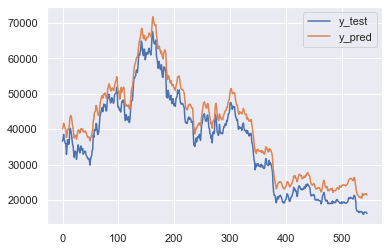

In [25]:
pd.DataFrame(zip(Y_test,y_pred),columns=['y_test','y_pred']).plot()

In [27]:
pre_df.to_csv("btc_NN.csv")